In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10


2024-04-07 16:27:45.548566: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 16:27:45.548617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 16:27:45.550171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [53]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Flatten,Dropout, MaxPooling2D,Dense, Reshape, Conv2DTranspose,GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [41]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Split training data into training and validation sets
split = int(0.8 * len(x_train))
x_val = x_train[split:]
x_train = x_train[:split]

y_val = y_train[split:]
y_train = y_train[:split]


In [42]:
# Reshape the data
x_train = x_train.reshape(-1, 32, 32, 3)
x_val = x_val.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)


In [43]:
# Define the encoder architecture
def build_encoder(input_shape, latent_dim):
    input_img = Input(shape=input_shape)
    
    x = Conv2D(64, (3, 3), strides=2, padding="same")(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Flatten()(x)
    
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    # Sampling
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    return Model(input_img, [z_mean, z_log_var])

In [57]:
def build_classifier(encoder, num_classes):
    # Retrieve the output tensors from the encoder
    z_mean, z_log_var = encoder.output
    
    # Reshape the z_mean tensor to have the correct dimensions
    reshaped_z_mean = Reshape((-1, 1, 1))(z_mean)
    
    # Add classifier layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(reshaped_z_mean)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    
    x = Flatten()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    output = Dense(num_classes, activation='softmax')(x)

    # Create the classifier model
    classifier = Model(inputs=encoder.input, outputs=output)
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier


In [58]:
from tensorflow.keras.utils import to_categorical
# Assuming 'latent_dim' is the dimension of the latent space
latent_dim = 100
encoder = build_encoder(input_shape=(32, 32, 3), latent_dim=latent_dim)

# Assuming 'num_classes' is the number of classes for classification
num_classes = 10  # Example number of classes
classifier = build_classifier(encoder, num_classes)

# Convert target data to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)



Epoch 1/20
 23/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0883 - loss: 2.3064

W0000 00:00:1712509538.100979    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712509538.102743    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2815 - loss: 1.9098

W0000 00:00:1712509542.540886    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712509542.542401    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.2823 - loss: 1.9081 - val_accuracy: 0.4040 - val_loss: 1.6649
Epoch 2/20
 34/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5076 - loss: 1.4285

W0000 00:00:1712509543.604452    1771 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712509543.605545    1771 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5238 - loss: 1.3481 - val_accuracy: 0.5139 - val_loss: 1.3657
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6004 - loss: 1.1512 - val_accuracy: 0.6049 - val_loss: 1.1431
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6556 - loss: 1.0044 - val_accuracy: 0.5247 - val_loss: 1.3908
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6990 - loss: 0.8841 - val_accuracy: 0.5527 - val_loss: 1.4622
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7385 - loss: 0.7715 - val_accuracy: 0.6383 - val_loss: 1.1371
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7761 - loss: 0.6571 - val_accuracy: 0.6384 - val_loss: 1.1466
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8057 - loss: 0.5789 - val_accuracy: 0.6437 - val_loss: 1.1867
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8279 - loss: 0.5096 - val_accuracy: 0.6235 - val_

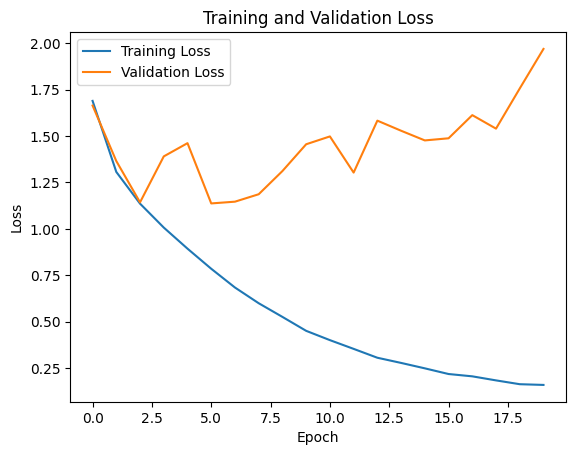

In [59]:
import matplotlib.pyplot as plt

# Train the classifier and store the training history
history = classifier.fit(x_train, y_train_one_hot, epochs=20, batch_size=64, validation_data=(x_val, y_val_one_hot))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

 84/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1712509621.754697    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712509621.755802    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


W0000 00:00:1712509622.913759    1771 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712509622.914877    1771 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy: 0.6011
Precision: 0.6394636252438294
Recall: 0.6011
F1-Score: 0.6042922015315257


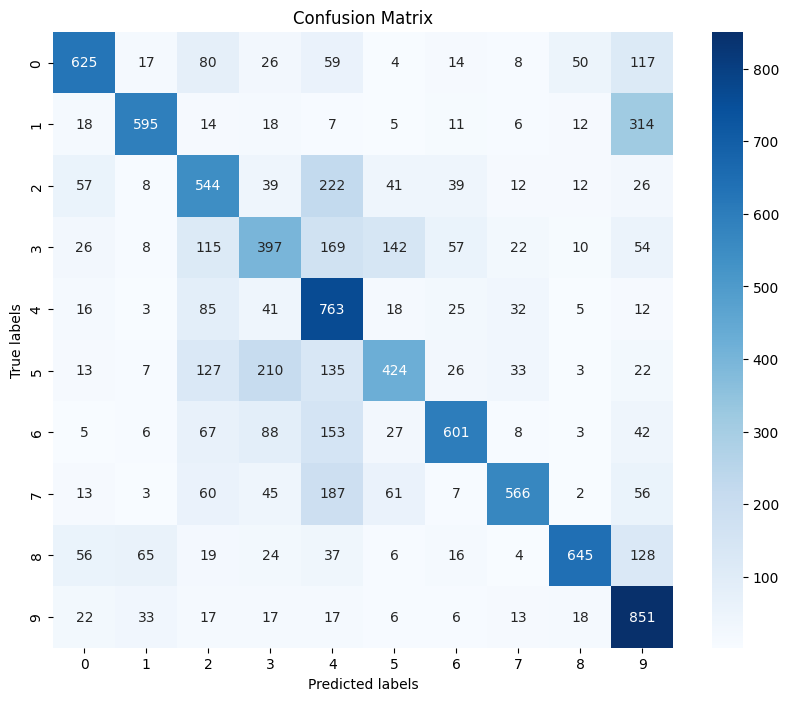

In [60]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns


y_test_one_hot = to_categorical(y_test, num_classes)


# Predict classes for the test data
y_pred = classifier.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
